<a href="https://colab.research.google.com/github/cosh14/Project/blob/master/Increased%20Mismatch%20to%20avoid%20micro-domain%20formations%20in%20FM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

2.0 1.8683738932576048 1.884047539149095 1.9961743369388436
123 186
2.0 1.895208806126706 1.5524239793081134 1.434053343061971
J grid expected values =22878 and J grid returned values = 22878
(123, 186)


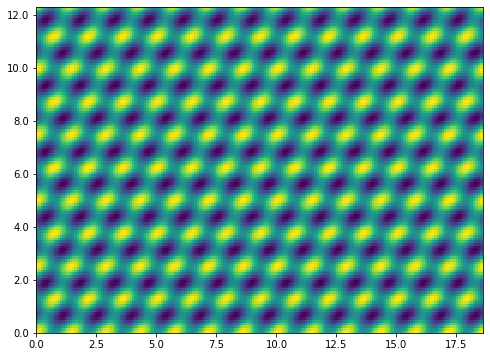

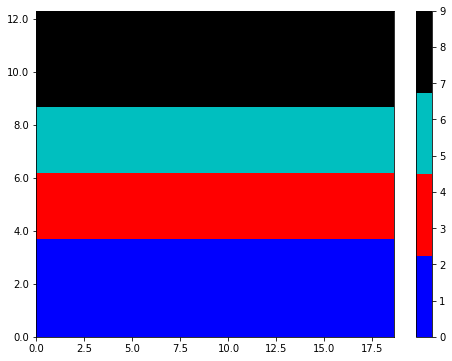

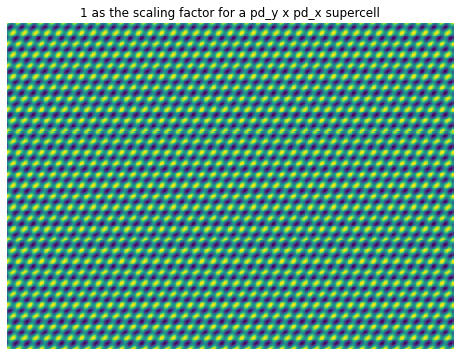

In [2]:
import numpy as np 
np.set_printoptions(threshold=1000)
import numba as nb
from numba import jit
import matplotlib.pyplot as plt 
from scipy.constants import pi
from matplotlib import colors as c
import matplotlib.gridspec as gridspec
import numpy.ma as ma
from numpy.ma.core import concatenate, size
from numpy.random import randint as rd 
from numpy.random import rand 
from matplotlib.pyplot import arrow, axis, figure, imshow, pcolormesh, rc_context, title
from matplotlib.colors import from_levels_and_colors as lc
import itertools 
import time 
plt.rcParams["figure.figsize"] = (8,6)
start_time = time.time() 
d = 2.0
do = 2.05
bin_freq = 0.1

#formatting of arrays in numpy is (y,x) see shapes in https://note.nkmk.me/en/python-numpy-ndarray-ndim-shape-size/
K1 = np.array([(4*pi)/(d*np.sqrt(3)),0])
K2 = np.array([(4*pi)/(do*np.sqrt(3)),0])
K3 = np.array([(-2*pi)/(d*np.sqrt(3)),2*pi/d])
K4 = np.array([(-2*pi)/(do*np.sqrt(3)),2*pi/do])

#periodicity in x ~ 122, range ~ [119,123]
#periodicity in y ~ 140
# all definitions for d=2.0, do=2.01, bin freq = 0.1
# start with 70,120 for N=1
pd_x = 100
pd_y = 100
N=1

J = np.zeros((N*pd_y,N*pd_x))
R_x = np.zeros((N*pd_y,N*pd_x))
R_y = np.zeros((N*pd_y,N*pd_x))

for i in range (N*pd_y):
  for j in range (N*pd_x): 
    R = np.array([i*bin_freq,j*bin_freq])
    R_x[i][j] = j*bin_freq
    R_y[i][j] = i*bin_freq
    J[i,j] = np.cos((180/np.pi)*(np.dot(R,K4-K3)))+(np.cos((180/np.pi)*(np.dot(R,K2-K1))))
    

print(J[0][0], J[0][-1], J[-1][-1], J[-1][0])

check_J = J[0][-1]
while check_J < 1.999:
  pd_x+=1
  cR = np.array([0,N*pd_x*bin_freq])
  check_J = np.cos(180/pi*np.dot(cR,K2-K1)) + np.cos(180/pi*np.dot(cR,K4-K3))

check_J = J[-1][0]
while check_J < 1.999:
  pd_y+=1
  cR = np.array([N*pd_y*bin_freq,0])
  check_J = np.cos(180/pi*np.dot(cR,K2-K1)) + np.cos(180/pi*np.dot(cR,K4-K3))

#pd_x+=1
pd_y-=1
print(pd_y,pd_x)

J = np.zeros((N*pd_y,N*pd_x))
J_dmn_x = np.zeros((N*pd_y,N*pd_x))
J_dmn_y = np.zeros((N*pd_y,N*pd_x))
R_x = np.zeros((N*pd_y,N*pd_x))
R_y = np.zeros((N*pd_y,N*pd_x))

for i in range (N*pd_y):
  for j in range (N*pd_x): 
    R = np.array([i*bin_freq,j*bin_freq])
    R_x[i][j] = j*bin_freq
    R_y[i][j] = i*bin_freq
    J[i,j] = np.cos((180/np.pi)*(np.dot(R,K4-K3)))+(np.cos((180/np.pi)*(np.dot(R,K2-K1))))
    J_dmn_x[i,j] = np.floor(-1/(0.01736*2*pi)*np.dot(R,K2-K1))
    J_dmn_y[i,j] = np.floor(-1/(0.01736*2*pi)*np.dot(R,K4-K3)) 

print(J[0][0], J[0][-1], J[-1][-1], J[-1][0])

print("J grid expected values =%d and J grid returned values = %d" %((N*N*pd_y*pd_x) ,J.size)) #<- This does it

print(J.shape)

fig, ax = plt.subplots()
pcolormesh(J)
ticksx = ax.get_xticks()*bin_freq
ax.set_xticklabels(ticksx)
ticksy = ax.get_yticks()*bin_freq
ax.set_yticklabels(ticksy)
plt.show()

fig, ax = plt.subplots()
cMap = c.ListedColormap(['b','r','c','k'])
pcolormesh(J_dmn_x, cmap=cMap) 
ticksx = ax.get_xticks()*bin_freq
ax.set_xticklabels(ticksx)
ticksy = ax.get_yticks()*bin_freq
ax.set_yticklabels(ticksy)
plt.colorbar()
plt.show()


def VisualMeshCheck(n): #useless mostly, visual check for periodicity
  plt.figure()
  gs1 = gridspec.GridSpec(n,n)
  gs1.update(wspace=0.0, hspace=0.0)
  for i in range(n*n):
    #figure(num=None, figsize=(51, 25.5), dpi=120, facecolor='w', edgecolor='k')
    plt.subplot(gs1[i])
    plt.pcolormesh(J)
    plt.axis('off')
    plt.grid('false')
    if i==1:
      plt.title('%i as the scaling factor for a pd_y x pd_x supercell' %N)
VisualMeshCheck(3)


In [3]:
x_l = R_x[-1][-1]
y_l = R_y[-1][-1]
print(x_l,y_l)
sf = 0.02 #scaling factor to get grid
err = np.finfo(float).eps
print(err)

18.5 12.200000000000001
2.220446049250313e-16


In [4]:
@jit(nopython=True)
def Jdomassignment(coordinates):
  J_usable = np.zeros(len(coordinates))
  J_dmn_nr_x = np.zeros(len(coordinates))
  J_dmn_nr_xy = np.zeros(len(coordinates))
  J_dmn_nr = np.zeros(len(coordinates))
  
  for i in range (len(coordinates)):
    cd = np.array([coordinates[i][1],coordinates[i][0]])
    J_usable[i] = np.cos(180/pi*np.dot(cd,K2-K1)) + np.cos(180/pi*np.dot(cd,K4-K3))
    #if (J_usable[i]<0):
      #J_usable[i]*=10
    J_dmn_nr_x[i] = np.floor(-1/(0.01736*2*pi)*np.dot(cd,K2-K1))
    J_dmn_nr_xy[i] = np.floor(-1/(0.01736*2*pi)*np.dot(cd,K4-K3)) 
    J_dmn_nr[i] = 100*J_dmn_nr_x[i] + J_dmn_nr_xy[i]
  
  return J_usable,J_dmn_nr,J_dmn_nr_x, J_dmn_nr_xy


In [5]:
def CalcJ(sf):
  store_x_1 = np.arange(0,x_l+np.finfo(float).eps,d*sf)  
  store_x_2 = np.arange(d*sf*0.5,x_l+np.finfo(float).eps,d*sf)
  store_y_1 = np.arange(0,y_l+np.finfo(float).eps,d*0.866*2*sf)
  store_y_2 = np.arange(d*sf*0.866,y_l+np.finfo(float).eps,d*0.866*2*sf)
  xx, yy = np.meshgrid(store_x_1,store_y_1)
  ww, tt = np.meshgrid(store_x_2,store_y_2)
  xGridSize = len(store_x_1)+len(store_x_2) #each dimension includes a blank/masked element hence the sum
  yGridSize = len(store_y_1)+len(store_y_2)
  #print(xGridSize,yGridSize)

  temp_x = xx.tolist()
  temp_y = yy.tolist()
  set_1 = list(zip(temp_x[0], temp_y[0]))
  for i in range (1,len(store_y_1)):
      temp = list(zip(temp_x[i], temp_y[i]))
      for j in range (len(store_x_1)):
          set_1.append(temp[j])  

  temp_xo = ww.tolist()
  temp_yo = tt.tolist()
  set_2 = list(zip(temp_xo[0], temp_yo[0]))
  for i in range (1,len(store_y_2)):
      temp = list(zip(temp_xo[i], temp_yo[i]))
      for j in range (len(store_x_2)):
          set_2.append(temp[j])  
  
  del store_x_1
  del store_x_2
  del store_y_1
  del store_y_2

  coordinates = set_1 + set_2
  tx = np.zeros(len(coordinates))
  ty = np.zeros(len(coordinates))

  for i in range(len(coordinates)):
      tx [i] = coordinates[i][0]*(1/bin_freq) #tx only stores all x values (abcissa) of the coordinates list for plotting purposes
      ty [i] = coordinates[i][1]*(1/bin_freq)
    
  coord_x = tx.tolist()
  coord_y = ty.tolist()

  J_usable,J_dmn_nr,J_dmn_nr_x, J_dmn_nr_xy = Jdomassignment(nb.typed.List(coordinates))

  return coordinates, J_usable, tx, ty, xGridSize, yGridSize, J_dmn_nr,J_dmn_nr_x, J_dmn_nr_xy

print(CalcJ (sf)[5])


353


In [6]:
def plotJ(sf, bl):  #bl = 1 for annotations or 0 for no annotations
  print(J.shape)
  coordinates,J_usable,tx,ty,J_dmn_nr = CalcJ(sf)[0],CalcJ(sf)[1],CalcJ(sf)[2],CalcJ(sf)[3],CalcJ(sf)[6]
  print('Number of triangular points to be used = %d' %len(coordinates))
  fig, ax = plt.subplots(figsize=(12,24))
  style = dict(size=10, color='b')
  pcolormesh(J, alpha = 0.25)
  ax.scatter(tx,ty,marker='o',c = 'r',s=10)
  if bl ==1 :
    for i in range (len(coordinates)):
      ax.text(tx[i],ty[i],"(%.1f,%.3f) J=%.4f %.5f" %(coordinates[i][0],coordinates[i][1],J_usable[i],J_dmn_nr[i]),**style)
  ticksx = ax.get_xticks()*bin_freq
  ax.set_xticklabels(ticksx)
  ticksy = ax.get_yticks()*bin_freq
  ax.set_yticklabels(ticksy)
  plt.title('Scaling factor = %.3f' %sf)
  plt.show()

1.430
(123, 186)
Number of triangular points to be used = 163263


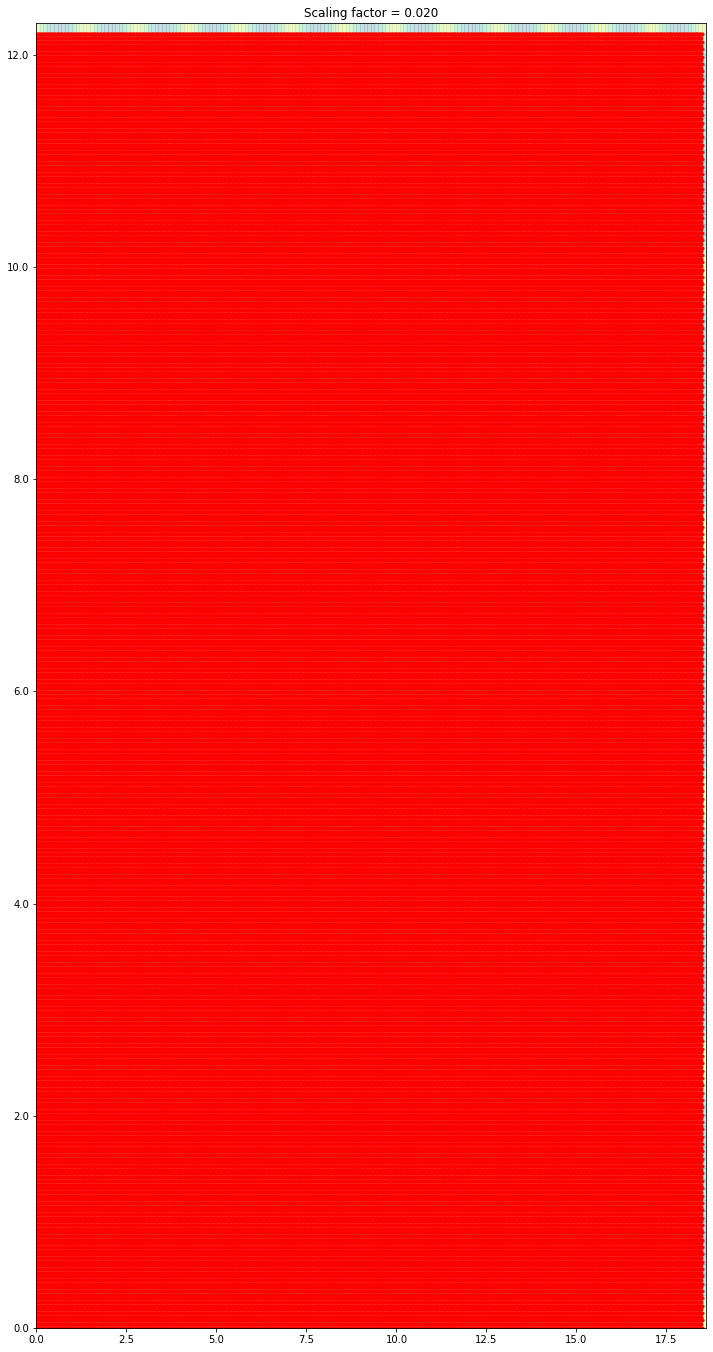

(123, 186)
Number of triangular points to be used = 33


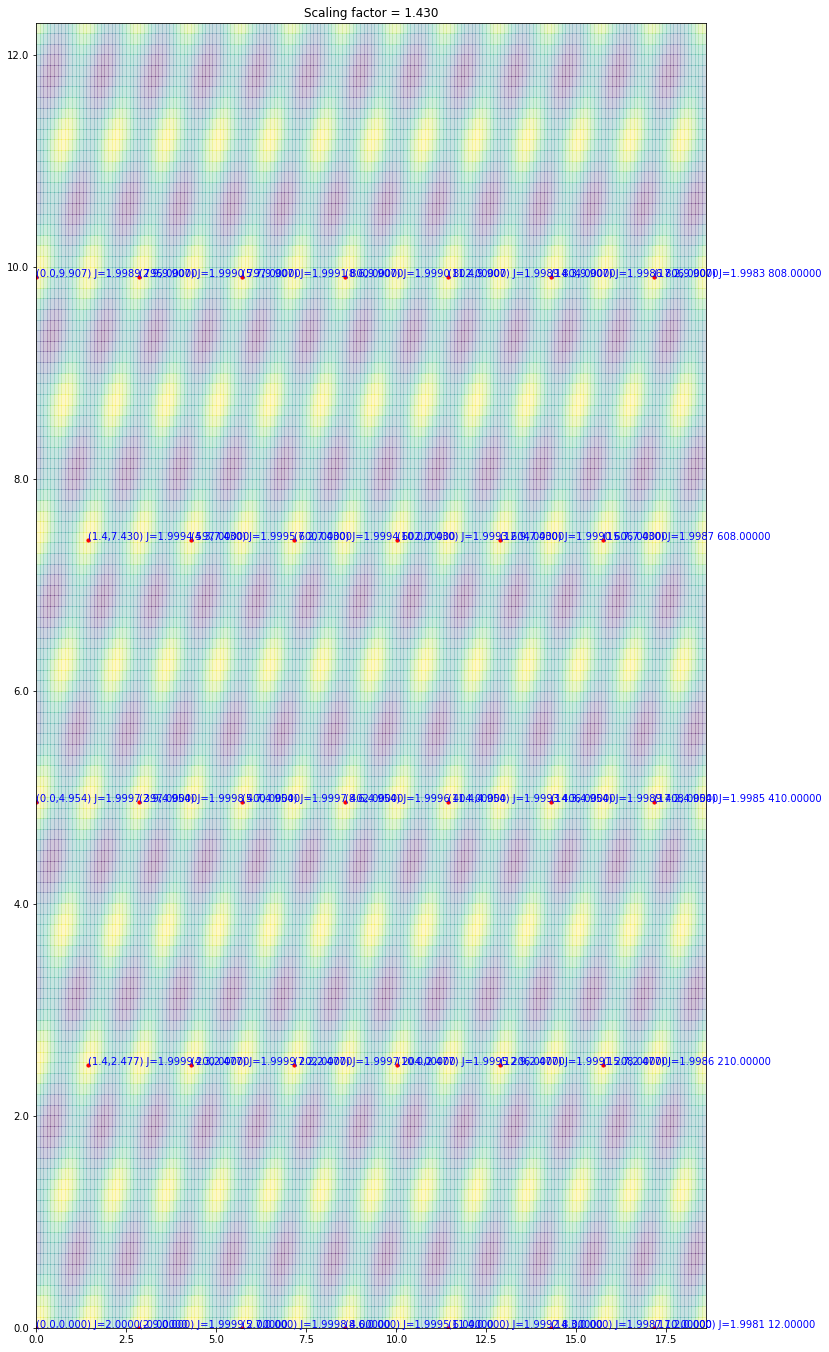

In [7]:
sf_p = 1 #principal scaling factor to define domains
J_usa = CalcJ(sf_p)[1]
val = J_usa[1]
while val < 1.999:
  sf_p+=0.01 
  J_usa = CalcJ(sf_p)[1]
  val = J_usa[1]

print('%.3f' %sf_p)
plotJ(sf,0)
plotJ(sf_p,1)

In [8]:
sigma = 2 # 1: cold start, 2:hot start

In [9]:
@jit(nopython=True)
def TempFastFunc(ly,lx):
    ctr = 0
    mask_array = np.ones((ly,lx))
    J_grid_val = np.zeros((ly,lx))
    J_db_val = np.zeros((ly,lx))
    config = (2*rd(0,sigma,(ly,lx)))-1
    #config = (2*rd(0,1,(ly,lx)))-1
    #config = (2*rd(0,2,(ly,lx)))-1
    for i in range(ly):
      if (i%2==0):
        for j in range(lx):
              if (((i+j)%2)==0):
                  J_grid_val[i][j] = J_usable[ctr]
                  J_db_val[i][j] = J_dom_nr[ctr]
                  ctr+=1
    for i in range(ly):
      if (i%2!=0):
        for j in range(lx):
              if (((i+j)%2)==0):
                  J_grid_val[i][j] = J_usable[ctr]
                  J_db_val[i][j] = J_dom_nr[ctr]
                  ctr+=1
    for i in range(ly):
      for j in range(lx):
        if (((i+j)%2)==0):
          mask_array[i][j] = 0
    return config, J_grid_val, J_db_val, mask_array


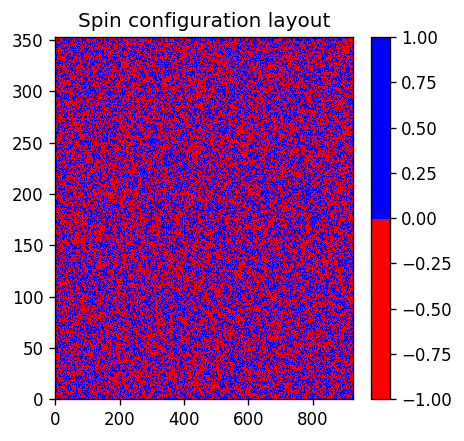

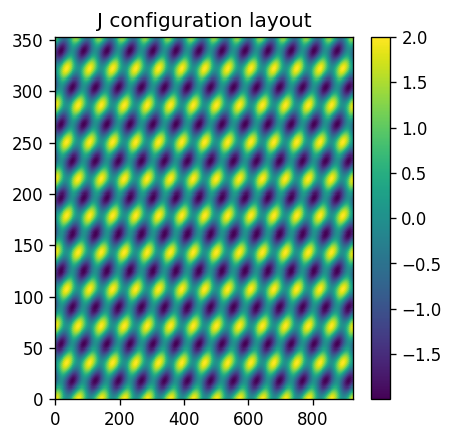

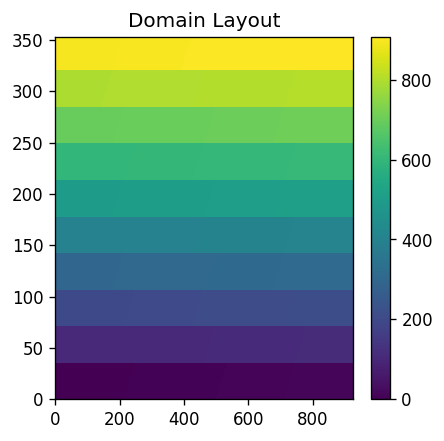

In [10]:
def GenerateTriLattice(ly,lx):
    config, J_grid_val, J_db_val, mask_array = TempFastFunc (ly,lx)
    use_config = ma.array(config, mask=mask_array)
    J_grid = ma.array(J_grid_val,mask=mask_array)
    J_db = ma.array(J_db_val,mask=mask_array)
    return use_config,J_grid,mask_array,J_db


J_usable, J_dom_nr, xGridSize, yGridSize = CalcJ(sf)[1], CalcJ(sf)[6], CalcJ(sf)[4], CalcJ(sf)[5]
cMap = c.ListedColormap(['r','b'])
config, J_grid_val, mask_array, J_db_val = GenerateTriLattice(yGridSize,xGridSize)

figure(num=None, figsize=(4, 4), dpi=120, facecolor='w', edgecolor='k')
pcolormesh(config, cmap=cMap)
plt.title('Spin configuration layout')
plt.colorbar()
plt.show()


fig, ax = plt.subplots(figsize=(4,4),dpi=120, facecolor='w', edgecolor='k')
cMap = c.ListedColormap(['b','g','r','c','m','y','k'])
pcolormesh(J_grid_val)
plt.title('J configuration layout')
plt.colorbar()
plt.show()
"""
n=3
plt.figure(figsize = (6,12))
gs1 = gridspec.GridSpec(n,n)
gs1.update(wspace=0.002, hspace=0.002)
for i in range(n*n):
  #figure(num=None, figsize=(51, 25.5), dpi=120, facecolor='w', edgecolor='k')
  plt.subplot(gs1[i])
  plt.pcolormesh(J_grid_val)
  plt.axis('on')
  plt.grid('false')
  if i==1:
    plt.title('%i as the scaling factor for a pd_y x pd_x supercell' %N)
"""
figure(num=None, figsize=(4, 4), dpi=120, facecolor='w', edgecolor='k')
cMap = c.ListedColormap(['r','b','y','m','g'])
pcolormesh(J_db_val)
plt.title('Domain Layout')
plt.colorbar()
plt.show()


In [11]:
def wrapJdom(J_db):
  first_col = J_db[:,0]  
  last_col = J_db[:,-1] 
  for i in range (len(first_col)):
    if (first_col[i] == -5 or last_col[i] ==-5):
      continue
    else:
      if (last_col[i] != first_col[i]) and (np.count_nonzero(first_col == first_col[i])>10) and (np.count_nonzero(last_col == last_col[i])>10):# and (np.count_nonzero(first_col == first_col[i])>(len(first_col)/len(np.unique(first_col))):
        print('Mismatch identified (%d,%d)' %(last_col[i],first_col[i]))
        print('Swapping %d to %d' %(last_col[i],first_col[i]))
        J_db[J_db == last_col[i]] =  np.minimum(first_col[i],last_col[i])
  return J_db

(uniq, cnt) = np.unique(J_db_val, return_counts=True)
freqs = np.asarray((uniq, cnt)).T
print(freqs)
for i in range (len(uniq)-1):
  if cnt[i] < 100:
    J_db_val[J_db_val == uniq[i]] = (uniq[i]-1)%len(uniq)





[[-1.00000e+00  3.06000e+02]
 [ 0.00000e+00  1.29600e+03]
 [ 1.00000e+00  1.29600e+03]
 [ 2.00000e+00  1.26000e+03]
 [ 3.00000e+00  1.29600e+03]
 [ 4.00000e+00  1.26000e+03]
 [ 5.00000e+00  1.29600e+03]
 [ 6.00000e+00  1.29600e+03]
 [ 7.00000e+00  1.26000e+03]
 [ 8.00000e+00  1.29600e+03]
 [ 9.00000e+00  1.26000e+03]
 [ 1.00000e+01  1.29600e+03]
 [ 1.10000e+01  1.29600e+03]
 [ 1.20000e+01  9.36000e+02]
 [ 9.90000e+01  9.54000e+02]
 [ 1.00000e+02  1.29600e+03]
 [ 1.01000e+02  1.29600e+03]
 [ 1.02000e+02  1.26000e+03]
 [ 1.03000e+02  1.29600e+03]
 [ 1.04000e+02  1.26000e+03]
 [ 1.05000e+02  1.29600e+03]
 [ 1.06000e+02  1.29600e+03]
 [ 1.07000e+02  1.26000e+03]
 [ 1.08000e+02  1.29600e+03]
 [ 1.09000e+02  1.26000e+03]
 [ 1.10000e+02  1.29600e+03]
 [ 1.11000e+02  1.29500e+03]
 [ 1.12000e+02  2.89000e+02]
 [ 1.98000e+02  3.24000e+02]
 [ 1.99000e+02  1.22500e+03]
 [ 2.00000e+02  1.26000e+03]
 [ 2.01000e+02  1.26000e+03]
 [ 2.02000e+02  1.22500e+03]
 [ 2.03000e+02  1.26000e+03]
 [ 2.04000e+02

(326525,)
Mismatch identified (13,0)
Swapping 13 to 0
Mismatch identified (27,14)
Swapping 27 to 14
Mismatch identified (41,28)
Swapping 41 to 28
Mismatch identified (55,42)
Swapping 55 to 42
Mismatch identified (69,56)
Swapping 69 to 56
Mismatch identified (83,70)
Swapping 83 to 70
Mismatch identified (97,84)
Swapping 97 to 84
Mismatch identified (111,98)
Swapping 111 to 98
Mismatch identified (125,112)
Swapping 125 to 112
Mismatch identified (139,126)
Swapping 139 to 126


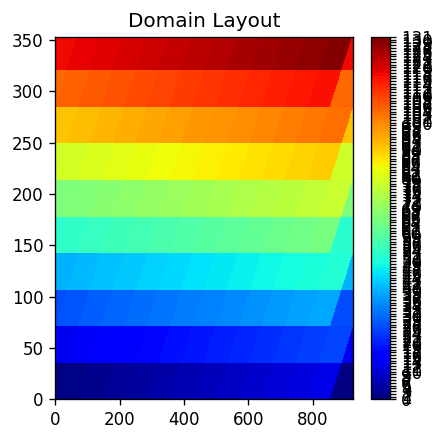

[Domain Number    Number of points]
[[     0   1242]
 [     1   1296]
 [     2   1296]
 [     3   1260]
 [     4   1296]
 [     5   1260]
 [     6   1296]
 [     7   1296]
 [     8   1260]
 [     9   1296]
 [    10   1260]
 [    11   1296]
 [    12   1296]
 [    13   1243]
 [    14   1296]
 [    15   1296]
 [    16   1260]
 [    17   1296]
 [    18   1260]
 [    19   1296]
 [    20   1296]
 [    21   1260]
 [    22   1296]
 [    23   1260]
 [    24   1296]
 [    25   1295]
 [    26   1243]
 [    27   1225]
 [    28   1260]
 [    29   1260]
 [    30   1225]
 [    31   1260]
 [    32   1225]
 [    33   1260]
 [    34   1260]
 [    35   1225]
 [    36   1260]
 [    37   1225]
 [    38   1260]
 [    39   1278]
 [    40   1260]
 [    41   1296]
 [    42   1296]
 [    43   1260]
 [    44   1296]
 [    45   1260]
 [    46   1296]
 [    47   1296]
 [    48   1260]
 [    49   1296]
 [    50   1260]
 [    51   1296]
 [    52   1242]
 [    53   1260]
 [    54   1225]
 [    55   1260]
 [    56   1

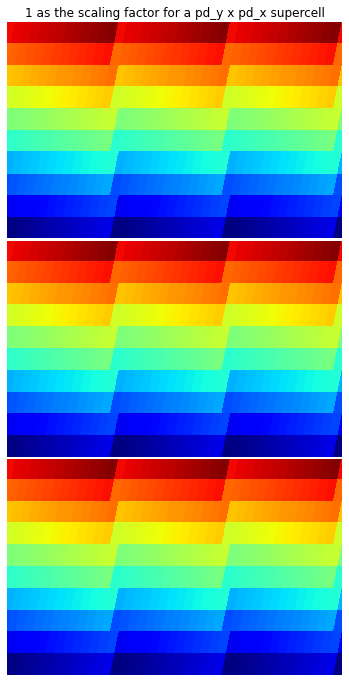

In [12]:
lt = np.unique(J_db_val, return_inverse=True)[1]
print(lt.shape)

J_db_val1 = lt.reshape(yGridSize,xGridSize)
J_db_val_temp = ma.array(J_db_val1,mask=mask_array)
arr = ma.filled(J_db_val_temp,-5)
J_db_val2 = ma.array(wrapJdom(arr),mask=mask_array) 

for i in range (len(np.unique(J_db_val2))-1):
  J_db_val2[J_db_val2 == np.unique(J_db_val2)[i]] = i

levels = [ 0,  1,  2,  3,     4,  5,  6,  7,  8,        9,     10,     11,        12,     13,     14,       15,       16, 17, 18]
colors = ['b','g','r','gray','c','m','y','k', 'crimson','cyan','coral','lawngreen','navy','teal','fuchsia','thistle','gold','w']
#colors = ['b','b','b','g',   'b','b','b','b','b',      'b',    'b',    'b',       'b',    'g',    'g',      'b',    'b', 'b']
#levels = np.arange(0,len(J_db_val2),1)
#y = rd(0,100,size=(len(levels)-1,4))
#colors = [str(item/101) for item in y]
#print(colors)
from matplotlib import cm
cm_subsection = np.linspace(0, 1,len(np.unique(J_db_val2))) 
colors = [ cm.jet(x) for x in cm_subsection ]
levels = np.arange(0,len(np.unique(J_db_val2))+1,1)
cmap, norm = lc(levels, colors)

figure(num=None, figsize=(4, 4), dpi=120, facecolor='w', edgecolor='k')
pcolormesh(J_db_val2,cmap = cmap,norm=norm)
plt.title('Domain Layout')
plt.colorbar(ticks=levels)
plt.show()


(unique, counts) = np.unique(J_db_val2, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print('[Domain Number    Number of points]')
print(frequencies)

plt.figure(figsize = (6,12))
gs1 = gridspec.GridSpec(3,3)
gs1.update(wspace=0.0, hspace=0.01)
for i in range(3*3):
  #figure(num=None, figsize=(51, 25.5), dpi=120, facecolor='w', edgecolor='k')
  plt.subplot(gs1[i])
  plt.pcolormesh(J_db_val2,cmap=cmap,norm=norm)
  plt.axis('off')
  plt.grid('false')
  if i==1:
    plt.title('%i as the scaling factor for a pd_y x pd_x supercell' %N)


In [13]:
print(xGridSize,yGridSize)
print(config.shape)
print((248+2)%699)
#print(config[700][0])

925 353
(353, 925)
250


In [14]:
a = rd (0,yGridSize) 
b = rd (0,xGridSize) 
print(a,b)
print(J_db_val2[a,b])
if (config [a,b] != 0):
  print(frequencies[J_db_val2[a,b]][1])

184 195
--


In [15]:
@jit(nopython=True)
def intxEcalcTri (Lattice,a,b,T):
    #Lattice = ma.filled(Lat,0)
    intrxE = 0 
    J_scale = J_grid_val[a,b]/T
    J_dm_nr = J_db_val2[a,b]
    s = Lattice[a,b]
    """
    print(a,b)
    print((a+2)%yGridSize)
    print((a-2)%yGridSize)
    print((b+2)%xGridSize)
    print((b-2)%xGridSize)
    print((a+1)%yGridSize)
    print((a-1)%yGridSize)
    print((b+1)%xGridSize)
    print((b-1)%xGridSize)    
    """
    if s == 0:
        return 0
    else:
        if Lattice [(a+2)%yGridSize,b] == s:  #W+W
            intrxE += -1
        else:
            intrxE += 1
        if Lattice [(a-2)%yGridSize,b] == s:  #S+S
            intrxE += -1
        else:
            intrxE += 1
        if Lattice [(a+1)%yGridSize,(b+1)%xGridSize] == s: #W+D
            intrxE += -1
        else:
            intrxE += 1
        if Lattice [(a+1)%yGridSize,(b-1)%xGridSize] == s: # W+A
            intrxE += -1
        else:
            intrxE += 1
        if Lattice [(a-1)%yGridSize,(b+1)%xGridSize] == s: #S+D
            intrxE += -1
        else:
            intrxE += 1
        if Lattice [(a-1)%yGridSize,(b-1)%xGridSize] == s: #S+A
            intrxE += -1
        else:
            intrxE += 1
        #print('J value used here = %f' %J_scale)    
    return -J_scale *intrxE

@jit(nopython=True)
def MetropolisMonteCarlo (Lat, T): 
    #Lattice = ma.filled(Lat,0)
    #print('MMC-en = %d,%d' %(Lattice.shape[0],Lattice.shape[1]))
    itr = 512*8
    stored_vals = 10
    #countc1 = 0
    #countc2 = 0
    count = 0
    count_1 = 0
    for j in range (itr): 
        for i in range (itr): 
            count_1 +=1
            a = rd (0,yGridSize) 
            b = rd (0,xGridSize)            
            while (Lat [a,b] == 0): 
              a = rd (0,yGridSize) 
              b = rd (0,xGridSize) 
            intrxE0 = intxEcalcTri (Lat, a, b, T) 
            Lat[a,b] *= -1
            intrxE1 = intxEcalcTri (Lat, a, b, T) 
            random = rand()
            """
            #To check individually which of the two conditions dominate spin flipping
            if (intrxE1-intrxE0) > 0 :
              countc1+= 1
            if random > np.exp(-(intrxE1-intrxE0)/T):
              countc2+=1
            """
            if (intrxE1-intrxE0) > 0 and random > np.exp(-(intrxE1-intrxE0)/T): #if the current spin config (post flip calculation) is greater energy than original, then flip back to original
                Lat[a,b] *=-1
                count+=1
    #Lat_return = ma.array(Lattice,mask=mask_array)
    #print('MMC_ex = %d,%d' %(Lat_return.shape[0],Lat_return.shape[1]))
    #return Lat, count, count_1, countc1, countc2
    return Lat

Transformed_Lattice = MetropolisMonteCarlo(config,1.5)


#Transformed_Lattice, count, count_1, countc1, countc2 = MetropolisMonteCarlo (config, 1.5) 
#print('Succesful flips = %d out of total attempts = %d' %(count_1-count,count_1))
#print('Condition 1 satisfied for %d of %d and condition 2 satisfied for %d of %d' %(countc1,count_1,countc2,count_1))



In [16]:
@jit(nopython=True)
def DomAvgMagCalc (Lattice,Nr):
  #Lattice = ma.filled(Lat,0)
  indx = np.argwhere(J_db_val2 == Nr) 
  mag = 0
  for i in range (len(indx)):
    y,x = indx[i][0], indx[i][1]
    mag+= Lattice[y][x]
  return (mag/frequencies[Nr][1])

print(config.shape)

@jit(nopython=True)
def DomSqMagCalc (Lattice, yGs, xGs, Nr):
  #Lattice = ma.filled(Lat,0)
  indx = np.argwhere(J_db_val2 == Nr) 
  mag_sq = 0
  for i in range(len(indx)):
    y,x = indx[i][0], indx[i][1]
    mag_sq += Lattice[y][x]*Lattice[y][x]
  return (mag_sq/frequencies[Nr][1])

@jit(nopython=True)
def DomSqEneCalc (Lattice,yGs, xGs,T, Nr): 
    indx = np.argwhere(J_db_val2 == Nr) 
    Ene_sq = 0 
    #Lattice = ma.filled(Lat,0)
    for i in range(len(indx)):
      y,x = indx[i][0], indx[i][1]
      Ene_sq += intxEcalcTri(Lattice,y,x,T)*intxEcalcTri(Lattice,y,x,T) 
    return (Ene_sq/frequencies[Nr][1]) 

@jit(nopython=True)
def DomEnergyCalc (Lattice,yGs, xGs,T, Nr): 
    indx = np.argwhere(J_db_val2 == Nr) 
    sum = 0 
    #Lattice = ma.filled(Lat,0)
    temp = np.zeros(len(indx)) 
    for i in range(len(indx)):
      y,x = indx[i][0], indx[i][1]
      temp[i] = intxEcalcTri(Lattice,y,x,T)  
    ans = np.sum(temp)/(frequencies[Nr][1])
    return ans 

(353, 925)


In [17]:
@jit(nopython=True)
def AvgMagCalc (Lattice): 
    #Lattice = ma.filled(Lat,0)
    mag = 0 
    mag = np.sum (Lattice)/(sites) 
    return mag 

@jit(nopython=True) 
def SqMagCalc (Lattice,yGs, xGs): 
    mag_sq = 0
    #Lattice = ma.filled(Lat,0)
    #print('Sqmagcalc = %d,%d' %(Lattice.shape[0],Lattice.shape[1])) 
    for i in range (yGs): 
        for j in range (xGs): 
            mag_sq += Lattice[i,j]*Lattice[i,j] 
    return mag_sq/(sites) 
 
@jit(nopython=True) 
def SqEneCalc (Lattice,yGs, xGs,T): 
    Ene_sq = 0 
    #Lattice = ma.filled(Lat,0)
    for i in range (yGs): 
        for j in range (xGs): 
            Ene_sq += intxEcalcTri(Lattice,i,j,T)*intxEcalcTri(Lattice,i,j,T) 
    return Ene_sq/(sites) 
 
@jit(nopython=True) 
def EnergyCalc (Lattice,yGs, xGs,T): 
    sum = 0 
    #Lattice = ma.filled(Lat,0)
    temp = np.zeros((yGs, xGs)) 
    for i in range (yGs): 
        for j in range (xGs): 
            temp[i][j] = intxEcalcTri(Lattice,i,j,T)  
    ans = np.sum (temp)/(sites) 
    return ans 


Number of sites = 163262


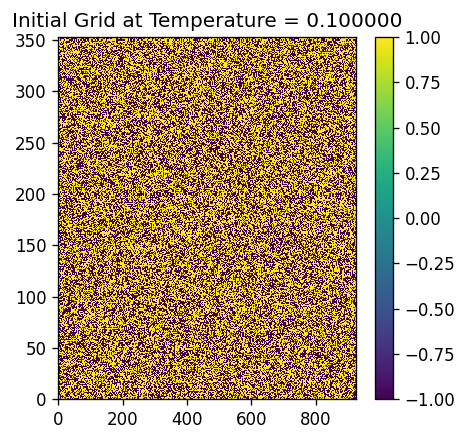

--- 6.124260663986206 seconds --- and 0 out of 250 loops done
--- 10.744022369384766 seconds --- and 1 out of 250 loops done
--- 15.296008110046387 seconds --- and 2 out of 250 loops done
--- 20.15508270263672 seconds --- and 3 out of 250 loops done
--- 24.683080911636353 seconds --- and 4 out of 250 loops done
--- 29.178201913833618 seconds --- and 5 out of 250 loops done
--- 33.59668564796448 seconds --- and 6 out of 250 loops done
--- 38.07846426963806 seconds --- and 7 out of 250 loops done
--- 42.6026656627655 seconds --- and 8 out of 250 loops done
--- 47.148857831954956 seconds --- and 9 out of 250 loops done
--- 51.75887608528137 seconds --- and 10 out of 250 loops done
--- 56.48853349685669 seconds --- and 11 out of 250 loops done
--- 61.10242462158203 seconds --- and 12 out of 250 loops done
--- 65.69439768791199 seconds --- and 13 out of 250 loops done
--- 70.29105496406555 seconds --- and 14 out of 250 loops done
--- 74.90493083000183 seconds --- and 15 out of 250 loops don

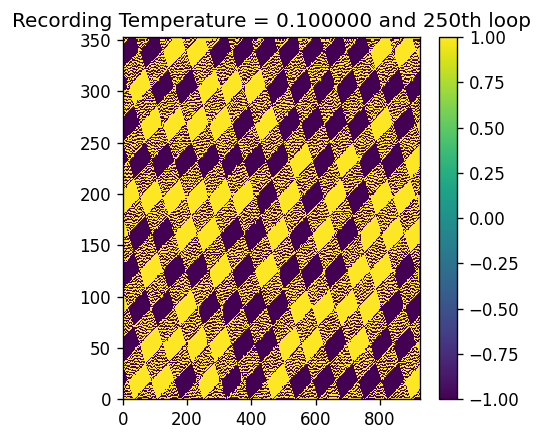

--- 1165.4917628765106 seconds ---


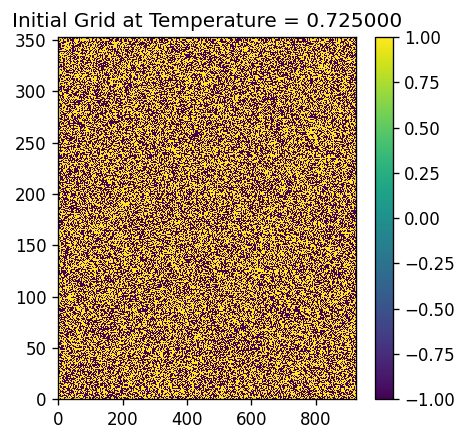

--- 4.924699068069458 seconds --- and 0 out of 250 loops done
--- 9.274354219436646 seconds --- and 1 out of 250 loops done
--- 13.668373584747314 seconds --- and 2 out of 250 loops done
--- 18.097475290298462 seconds --- and 3 out of 250 loops done
--- 22.66815757751465 seconds --- and 4 out of 250 loops done
--- 27.087584972381592 seconds --- and 5 out of 250 loops done
--- 31.513886213302612 seconds --- and 6 out of 250 loops done
--- 35.97714042663574 seconds --- and 7 out of 250 loops done
--- 40.353346824645996 seconds --- and 8 out of 250 loops done
--- 44.722895860672 seconds --- and 9 out of 250 loops done
--- 49.0804009437561 seconds --- and 10 out of 250 loops done
--- 53.42731213569641 seconds --- and 11 out of 250 loops done
--- 57.707154273986816 seconds --- and 12 out of 250 loops done
--- 62.03214168548584 seconds --- and 13 out of 250 loops done
--- 66.29180836677551 seconds --- and 14 out of 250 loops done
--- 70.56725430488586 seconds --- and 15 out of 250 loops done

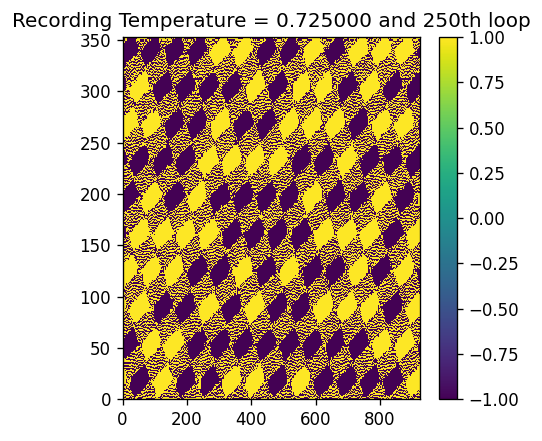

--- 2229.6813490390778 seconds ---


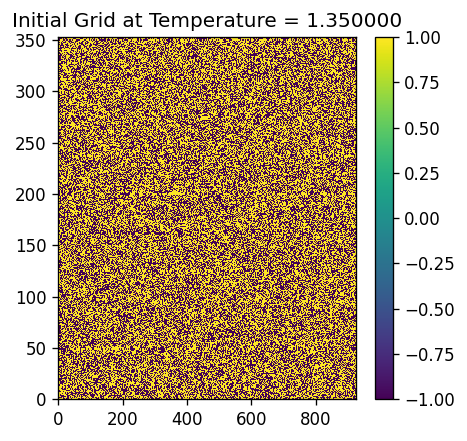

--- 4.668852090835571 seconds --- and 0 out of 250 loops done
--- 8.85091233253479 seconds --- and 1 out of 250 loops done
--- 13.089356184005737 seconds --- and 2 out of 250 loops done
--- 17.377412796020508 seconds --- and 3 out of 250 loops done
--- 21.68131375312805 seconds --- and 4 out of 250 loops done
--- 25.898183345794678 seconds --- and 5 out of 250 loops done
--- 30.179537296295166 seconds --- and 6 out of 250 loops done
--- 34.19994306564331 seconds --- and 7 out of 250 loops done
--- 38.295255184173584 seconds --- and 8 out of 250 loops done
--- 42.31951642036438 seconds --- and 9 out of 250 loops done
--- 46.35428428649902 seconds --- and 10 out of 250 loops done
--- 50.44176268577576 seconds --- and 11 out of 250 loops done
--- 54.475773334503174 seconds --- and 12 out of 250 loops done
--- 58.50372385978699 seconds --- and 13 out of 250 loops done
--- 62.538801193237305 seconds --- and 14 out of 250 loops done
--- 66.61261367797852 seconds --- and 15 out of 250 loops d

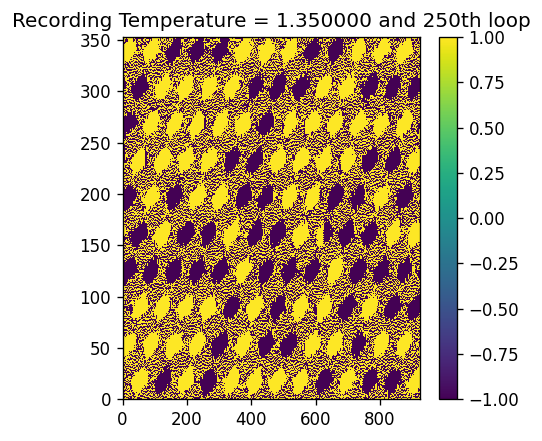

--- 3244.8860347270966 seconds ---


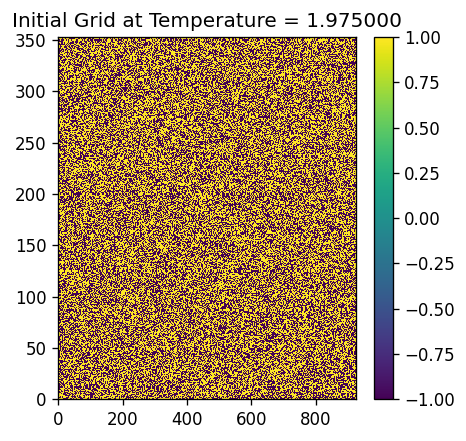

--- 4.716810941696167 seconds --- and 0 out of 250 loops done
--- 8.988357305526733 seconds --- and 1 out of 250 loops done
--- 13.268245697021484 seconds --- and 2 out of 250 loops done
--- 17.52089834213257 seconds --- and 3 out of 250 loops done
--- 21.753318786621094 seconds --- and 4 out of 250 loops done
--- 25.9818856716156 seconds --- and 5 out of 250 loops done
--- 30.159131050109863 seconds --- and 6 out of 250 loops done
--- 34.36783528327942 seconds --- and 7 out of 250 loops done
--- 38.54650378227234 seconds --- and 8 out of 250 loops done
--- 42.79050421714783 seconds --- and 9 out of 250 loops done
--- 47.041720390319824 seconds --- and 10 out of 250 loops done
--- 51.218493700027466 seconds --- and 11 out of 250 loops done
--- 55.43724036216736 seconds --- and 12 out of 250 loops done
--- 59.616339445114136 seconds --- and 13 out of 250 loops done
--- 63.78313589096069 seconds --- and 14 out of 250 loops done
--- 68.0074691772461 seconds --- and 15 out of 250 loops don

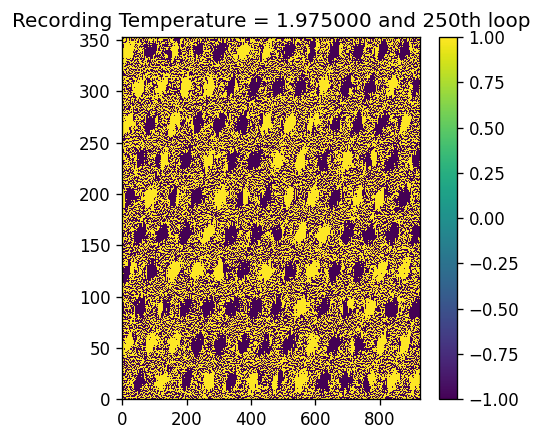

--- 4273.444051980972 seconds ---


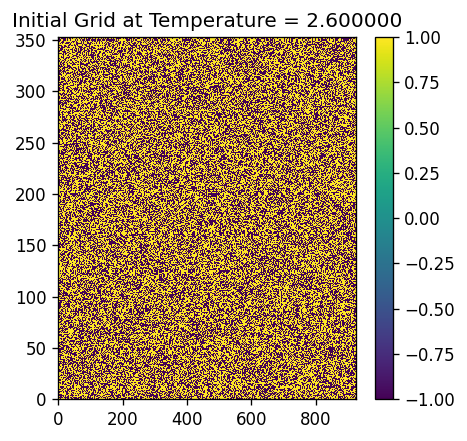

--- 4.800740480422974 seconds --- and 0 out of 250 loops done
--- 8.9752197265625 seconds --- and 1 out of 250 loops done
--- 13.146326303482056 seconds --- and 2 out of 250 loops done
--- 17.282580614089966 seconds --- and 3 out of 250 loops done
--- 21.51508665084839 seconds --- and 4 out of 250 loops done
--- 25.680664539337158 seconds --- and 5 out of 250 loops done
--- 29.779703378677368 seconds --- and 6 out of 250 loops done
--- 33.92146635055542 seconds --- and 7 out of 250 loops done
--- 38.20953416824341 seconds --- and 8 out of 250 loops done
--- 42.44110679626465 seconds --- and 9 out of 250 loops done
--- 46.60740113258362 seconds --- and 10 out of 250 loops done
--- 50.748071908950806 seconds --- and 11 out of 250 loops done
--- 54.940552949905396 seconds --- and 12 out of 250 loops done
--- 59.186118841171265 seconds --- and 13 out of 250 loops done
--- 63.33323693275452 seconds --- and 14 out of 250 loops done
--- 67.57866907119751 seconds --- and 15 out of 250 loops do

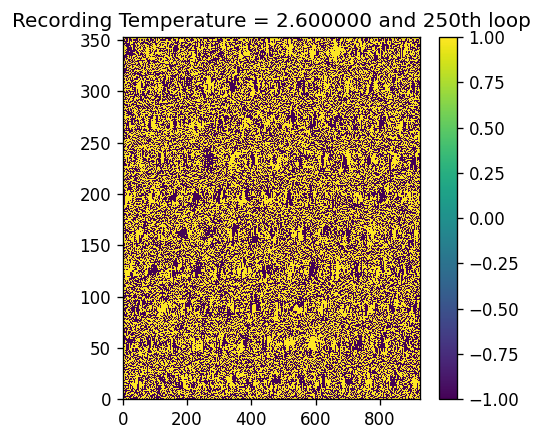

--- 5297.980889081955 seconds ---


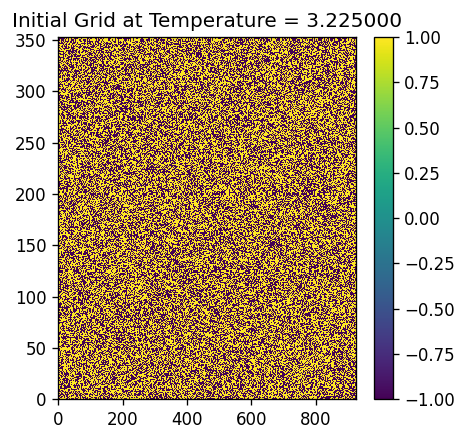

--- 4.649179697036743 seconds --- and 0 out of 250 loops done
--- 8.854252099990845 seconds --- and 1 out of 250 loops done
--- 12.973637342453003 seconds --- and 2 out of 250 loops done
--- 17.070122480392456 seconds --- and 3 out of 250 loops done
--- 21.155179977416992 seconds --- and 4 out of 250 loops done
--- 25.265862226486206 seconds --- and 5 out of 250 loops done
--- 29.405372619628906 seconds --- and 6 out of 250 loops done
--- 33.48277258872986 seconds --- and 7 out of 250 loops done
--- 37.653839111328125 seconds --- and 8 out of 250 loops done
--- 41.76416873931885 seconds --- and 9 out of 250 loops done
--- 45.81301236152649 seconds --- and 10 out of 250 loops done
--- 49.83554530143738 seconds --- and 11 out of 250 loops done
--- 53.875545263290405 seconds --- and 12 out of 250 loops done
--- 57.96258330345154 seconds --- and 13 out of 250 loops done
--- 62.05846166610718 seconds --- and 14 out of 250 loops done
--- 66.11266660690308 seconds --- and 15 out of 250 loops 

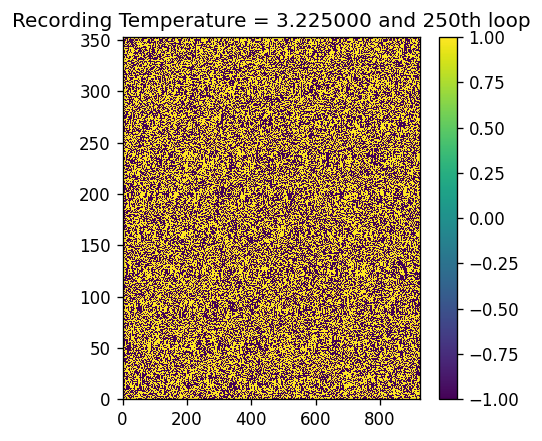

--- 6285.485634803772 seconds ---


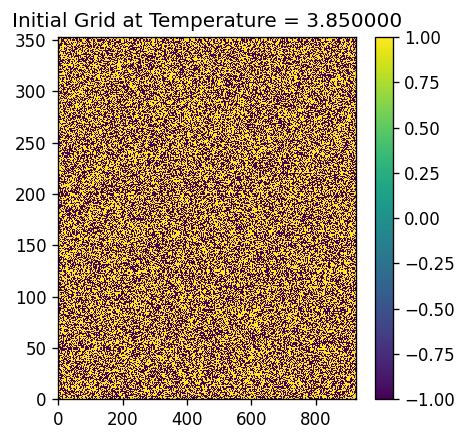

--- 4.6182169914245605 seconds --- and 0 out of 250 loops done
--- 8.606941938400269 seconds --- and 1 out of 250 loops done
--- 12.721889019012451 seconds --- and 2 out of 250 loops done
--- 16.915582180023193 seconds --- and 3 out of 250 loops done
--- 21.03817391395569 seconds --- and 4 out of 250 loops done
--- 25.06941819190979 seconds --- and 5 out of 250 loops done
--- 29.078088998794556 seconds --- and 6 out of 250 loops done
--- 33.067389488220215 seconds --- and 7 out of 250 loops done
--- 37.126306772232056 seconds --- and 8 out of 250 loops done
--- 41.147568225860596 seconds --- and 9 out of 250 loops done
--- 45.225077867507935 seconds --- and 10 out of 250 loops done
--- 49.29341745376587 seconds --- and 11 out of 250 loops done
--- 53.33427953720093 seconds --- and 12 out of 250 loops done
--- 57.34305024147034 seconds --- and 13 out of 250 loops done
--- 61.41787624359131 seconds --- and 14 out of 250 loops done
--- 65.51471734046936 seconds --- and 15 out of 250 loops

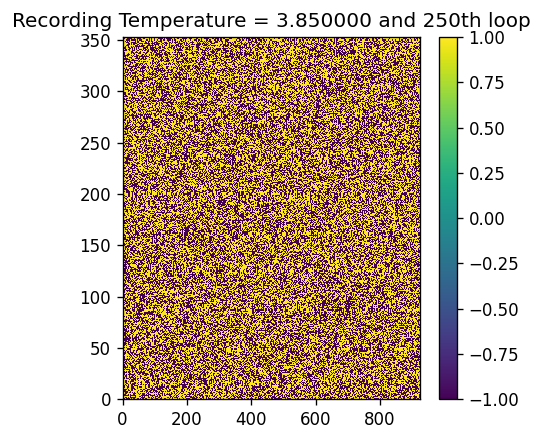

--- 7289.070538282394 seconds ---


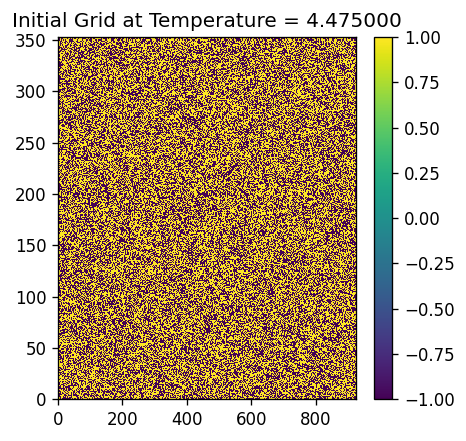

--- 4.610885143280029 seconds --- and 0 out of 250 loops done
--- 8.702701330184937 seconds --- and 1 out of 250 loops done
--- 12.8033607006073 seconds --- and 2 out of 250 loops done
--- 16.90984582901001 seconds --- and 3 out of 250 loops done
--- 20.928429126739502 seconds --- and 4 out of 250 loops done
--- 25.030194520950317 seconds --- and 5 out of 250 loops done
--- 29.083800077438354 seconds --- and 6 out of 250 loops done
--- 33.15792989730835 seconds --- and 7 out of 250 loops done
--- 37.20818901062012 seconds --- and 8 out of 250 loops done
--- 41.363465309143066 seconds --- and 9 out of 250 loops done
--- 45.51885223388672 seconds --- and 10 out of 250 loops done
--- 49.5974235534668 seconds --- and 11 out of 250 loops done
--- 53.70002460479736 seconds --- and 12 out of 250 loops done
--- 57.851279735565186 seconds --- and 13 out of 250 loops done
--- 61.98592495918274 seconds --- and 14 out of 250 loops done
--- 66.07461547851562 seconds --- and 15 out of 250 loops done

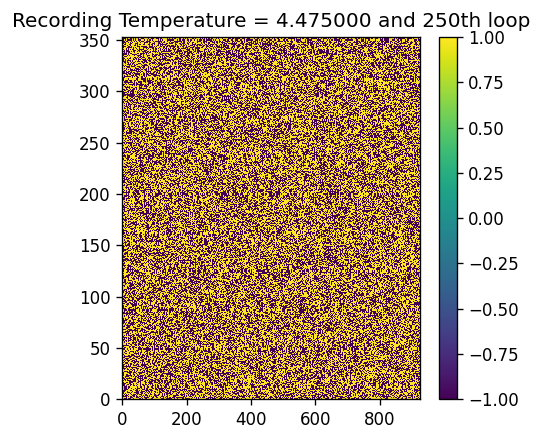

--- 8346.123669624329 seconds ---


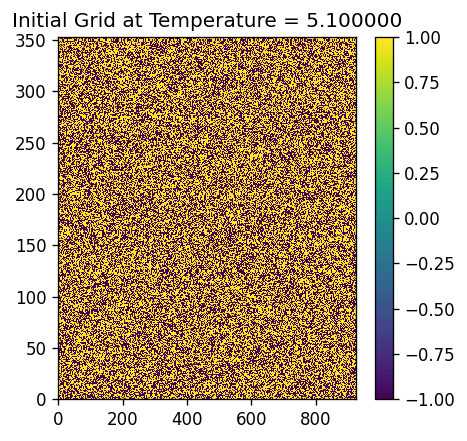

--- 4.715875864028931 seconds --- and 0 out of 250 loops done
--- 8.776306867599487 seconds --- and 1 out of 250 loops done
--- 12.990020751953125 seconds --- and 2 out of 250 loops done
--- 17.04976224899292 seconds --- and 3 out of 250 loops done
--- 21.01650357246399 seconds --- and 4 out of 250 loops done
--- 25.073233127593994 seconds --- and 5 out of 250 loops done
--- 29.0473792552948 seconds --- and 6 out of 250 loops done
--- 33.066948652267456 seconds --- and 7 out of 250 loops done
--- 37.06296896934509 seconds --- and 8 out of 250 loops done
--- 41.04669642448425 seconds --- and 9 out of 250 loops done
--- 45.06313610076904 seconds --- and 10 out of 250 loops done
--- 49.08637738227844 seconds --- and 11 out of 250 loops done
--- 53.19824552536011 seconds --- and 12 out of 250 loops done
--- 57.584335803985596 seconds --- and 13 out of 250 loops done
--- 61.833115339279175 seconds --- and 14 out of 250 loops done
--- 66.13073992729187 seconds --- and 15 out of 250 loops don

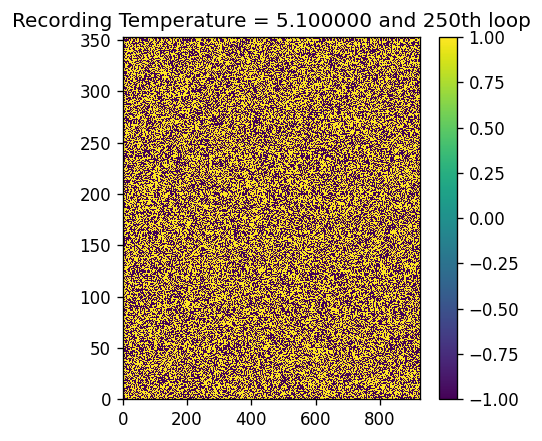

--- 9488.793014526367 seconds ---


In [18]:
plt.ioff()

myTval = np.linspace(0.1,5.1,9) 
N_loops = 250
config = GenerateTriLattice(xGridSize,yGridSize)[0]
sites = np.count_nonzero(config)/2 
print ('Number of sites = %d' %sites) 
bank_mag = np.zeros((len(myTval),N_loops)) 
bank_susc = np.zeros((len(myTval),N_loops)) 
bank_Cv = np.zeros((len(myTval),N_loops)) 
bank_dom_mag = np.zeros((len(myTval),len(unique)-2)) 
bank_dom_susc = np.zeros((len(myTval),len(unique)-2)) 
bank_dom_Cv = np.zeros((len(myTval),len(unique)-2)) 
#figure(num=None, figsize=(32, 24), dpi=120, facecolor='w', edgecolor='k')
#graph(config, tile) 
 
for i in range (len(myTval)): 
    tempo_mag = np.zeros(N_loops, dtype=float) 
    tempo_Cv = np.zeros(N_loops, dtype=float) 
    tempo_susc = np.zeros(N_loops, dtype=float) 
    tempo_dom_mag = np.zeros(len(unique)-2, dtype=float)
    tempo_dom_Cv = np.zeros(len(unique)-2, dtype=float)
    tempo_dom_susc = np.zeros(len(unique)-2, dtype=float)
    config = GenerateTriLattice(yGridSize,xGridSize)[0] 
    start_time1 = time.time() 
    #print('f1 = %d,%d' %(config.shape[0],config.shape[1]))
    figure(num=None, figsize=(4, 4), dpi=120, facecolor='w', edgecolor='k')
    pcolormesh(config)
    plt.colorbar()
    plt.title('Initial Grid at Temperature = %f' %myTval[i])
    plt.show()
    for m in range (N_loops): 
        config = MetropolisMonteCarlo(ma.filled(config,0), myTval[i])
        config_plot = ma.array(config,mask=mask_array)
        #print('f2 = %d,%d' %(config.shape[0],config.shape[1]))
        #print("--- %s T ---" % (myTval[i])) 
        #print("--- %s M ---" % (MagCalc(config)/(N*N))) 
        tempo_mag [m] = AvgMagCalc(config) 
        tempo_susc [m] = (1/myTval[i])*(SqMagCalc(config,yGridSize,xGridSize)-AvgMagCalc(config)*AvgMagCalc(config)) 
        tempo_Cv [m] = (1/(myTval[i]*myTval[i]))*(SqEneCalc(config,yGridSize,xGridSize,myTval[i])-EnergyCalc(config,yGridSize,xGridSize,myTval[i])*EnergyCalc(config,yGridSize,xGridSize,myTval[i])) 
        if (m%1 == 0):
          print("--- %s seconds --- and %d out of %d loops done" %(time.time() - start_time1,m,N_loops))
        if (m==(N_loops-1)):
          for z in range (len(unique)-2):
            tempo_dom_mag [z] = DomAvgMagCalc(config,z)
            tempo_dom_susc [z] = (1/myTval[i])*(DomSqMagCalc(config,yGridSize,xGridSize,z)-DomAvgMagCalc(config,z)*DomAvgMagCalc(config,z)) 
            tempo_dom_Cv [z] = (1/(myTval[i]*myTval[i]))*(DomSqEneCalc(config,yGridSize,xGridSize,myTval[i],z)-DomEnergyCalc(config,yGridSize,xGridSize,myTval[i],z)*DomEnergyCalc(config,yGridSize,xGridSize,myTval[i],z)) 
          #figure(num=None, figsize=(32, 24), dpi=120, facecolor='w', edgecolor='k')
          figure(num=None, figsize=(4, 4), dpi=120, facecolor='w', edgecolor='k')
          #pcolormesh(J_grid_val)
          pcolormesh(config_plot)#, alpha =0.05)
          plt.colorbar()
          plt.title('Recording Temperature = %f and %dth loop' %(myTval[i],m+1))
          #plt.savefig("/content/IsingPlots/plot" + str (myTval[i]) + "_" + str (m) + ".png")
          #plt.close()
          plt.show()
    print("--- %s seconds ---" % (time.time() - start_time)) 
    bank_mag [i] = tempo_mag 
    bank_susc [i] = tempo_susc 
    bank_Cv [i]  = tempo_Cv 
    bank_dom_mag [i] = tempo_dom_mag 
    bank_dom_susc [i] = tempo_dom_susc 
    bank_dom_Cv [i]  = tempo_dom_Cv 


In [ ]:
!zip -r /content/files.zip /content/IsingPlots

	zip warning: name not matched: /content/IsingPlots

zip error: Nothing to do! (try: zip -r /content/files.zip . -i /content/IsingPlots)


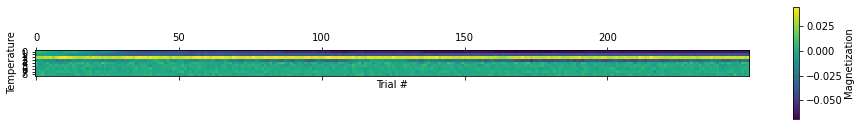

[-5.17100988e-02 -3.57964873e-02  3.63966496e-02 -2.33716377e-02
 -3.98229845e-04  1.98992420e-04 -2.39222112e-04  7.47262844e-05
 -1.42788454e-04]


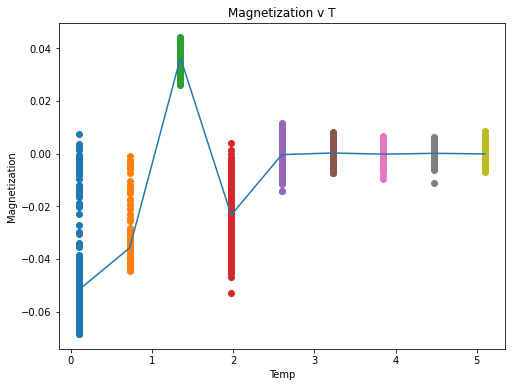

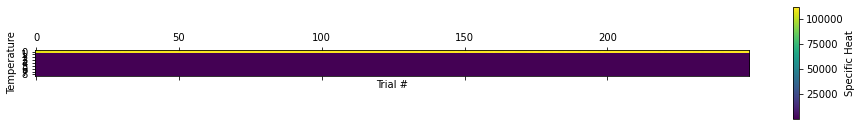

[1.10904637e+05 4.14862587e+01 3.74451650e+00 8.08111704e-01
 1.88284317e-01 6.42281768e-02 2.93578953e-02 1.56064970e-02
 9.10440840e-03]


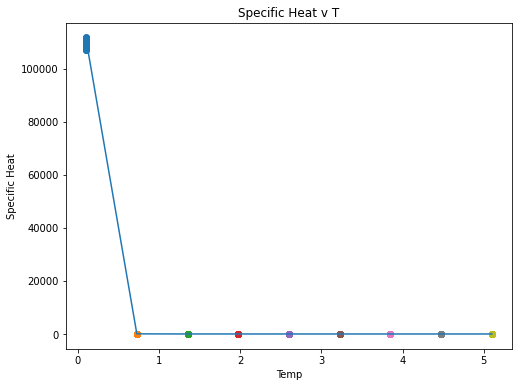

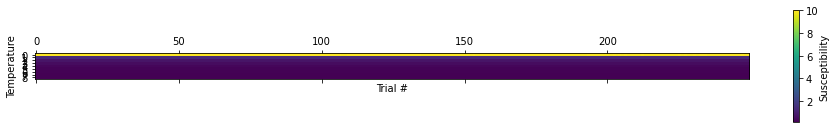

[9.97004337 1.37743788 0.73975219 0.50598261 0.38460709 0.31007594
 0.25973909 0.22346294 0.19607775]


<function matplotlib.pyplot.show>

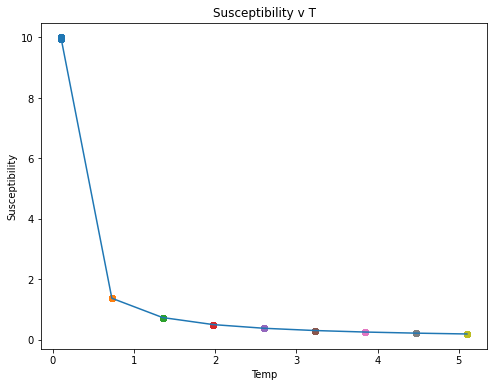

In [19]:
plt.matshow(bank_mag) 
plt.xlabel("Trial #") 
plt.ylabel("Temperature") 
cbar= plt.colorbar() 
cbar.set_label("Magnetization", labelpad=+1) 
plt.show() 
 
bank_avg_mag = np.zeros(len(myTval)) 
for i in range (len(myTval)): 
    bank_avg_mag[i] = np.average(bank_mag[i,:]) 
print (bank_avg_mag) 
 
for i in range (len(myTval)): 
    temp = np.full(N_loops,myTval[i]) 
    plt.scatter(temp, bank_mag[i]) 
plt.plot (myTval,bank_avg_mag) 
plt.title ("Magnetization v T") 
plt.xlabel("Temp") 
plt.ylabel("Magnetization") 
plt.show 
 
plt.matshow(bank_Cv) 
plt.xlabel("Trial #") 
plt.ylabel("Temperature") 
cbar= plt.colorbar() 
cbar.set_label("Specific Heat", labelpad=+1) 
plt.show() 
 
bank_avg_Cv = np.zeros(len(myTval)) 
for i in range (len(myTval)): 
    bank_avg_Cv[i] = np.average(bank_Cv[i,:]) 
print (bank_avg_Cv) 
 
for i in range (len(myTval)): 
    temp = np.full(N_loops,myTval[i]) 
    plt.scatter(temp, bank_Cv[i]) 
plt.plot (myTval,bank_avg_Cv) 
plt.title ("Specific Heat v T") 
plt.xlabel("Temp") 
plt.ylabel("Specific Heat") 
plt.show 
 
plt.matshow(bank_susc) 
plt.xlabel("Trial #") 
plt.ylabel("Temperature") 
cbar= plt.colorbar() 
cbar.set_label("Susceptibility", labelpad=+1) 
plt.show() 
 
bank_avg_susc = np.zeros(len(myTval)) 
for i in range (len(myTval)): 
    bank_avg_susc[i] = np.average(bank_susc[i,:]) 
print (bank_avg_susc) 
 
for i in range (len(myTval)): 
    temp = np.full(N_loops,myTval[i]) 
    plt.scatter(temp, bank_susc[i]) 
plt.plot (myTval,bank_avg_susc) 
plt.title ("Susceptibility v T") 
plt.xlabel("Temp") 
plt.ylabel("Susceptibility") 
plt.show 



In [20]:
from math import atan2,degrees
import numpy as np

#Label line with line2D label data
def labelLine(line,x,label=None,align=True,**kwargs):

    ax = line.axes
    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if (x < xdata[0]) or (x > xdata[-1]):
        print('x label location is outside data range!')
        return

    #Find corresponding y co-ordinate and angle of the line
    ip = 1
    for i in range(len(xdata)):
        if x < xdata[i]:
            ip = i
            break

    y = ydata[ip-1] + (ydata[ip]-ydata[ip-1])*(x-xdata[ip-1])/(xdata[ip]-xdata[ip-1])

    if not label:
        label = line.get_label()

    if align:
        #Compute the slope
        dx = xdata[ip] - xdata[ip-1]
        dy = ydata[ip] - ydata[ip-1]
        ang = degrees(atan2(dy,dx))

        #Transform to screen co-ordinates
        pt = np.array([x,y]).reshape((1,2))
        trans_angle = ax.transData.transform_angles(np.array((ang,)),pt)[0]

    else:
        trans_angle = 0

    #Set a bunch of keyword arguments
    if 'color' not in kwargs:
        kwargs['color'] = line.get_color()

    if ('horizontalalignment' not in kwargs) and ('ha' not in kwargs):
        kwargs['ha'] = 'center'

    if ('verticalalignment' not in kwargs) and ('va' not in kwargs):
        kwargs['va'] = 'center'

    if 'backgroundcolor' not in kwargs:
        kwargs['backgroundcolor'] = ax.get_facecolor()

    if 'clip_on' not in kwargs:
        kwargs['clip_on'] = True

    if 'zorder' not in kwargs:
        kwargs['zorder'] = 2.5

    ax.text(x,y,label,rotation=trans_angle,**kwargs)

def labelLines(lines,align=True,xvals=None,**kwargs):

    ax = lines[0].axes
    labLines = []
    labels = []

    #Take only the lines which have labels other than the default ones
    for line in lines:
        label = line.get_label()
        if "_line" not in label:
            labLines.append(line)
            labels.append(label)

    if xvals is None:
        xmin,xmax = ax.get_xlim()
        xvals = np.linspace(xmin,xmax,len(labLines)+2)[1:-1]

    for line,x,label in zip(labLines,xvals,labels):
        labelLine(line,x,label,align,**kwargs)

In [21]:
print(myTval,bank_mag)
print(len(bank_mag[:,-1]))
print(len(myTval))

[0.1   0.725 1.35  1.975 2.6   3.225 3.85  4.475 5.1  ] [[ 0.00353419  0.007344    0.00297068 ... -0.06177169 -0.06209019
  -0.06026491]
 [-0.00570247 -0.00092489 -0.00341168 ... -0.04048082 -0.04087283
  -0.04407013]
 [ 0.02690759  0.03103591  0.02997014 ...  0.03667101  0.03157492
   0.03668326]
 ...
 [-0.00952454 -0.00094939 -0.00420795 ...  0.00099839  0.00401194
  -0.00023888]
 [-0.0011944   0.00203966  0.00335043 ...  0.0045632  -0.00289717
   0.00232141]
 [-0.00045938  0.00293393  0.00847102 ...  0.00092489 -0.0017334
   0.00244392]]
9
9


x label location is outside data range!
x label location is outside data range!
x label location is outside data range!
x label location is outside data range!
x label location is outside data range!
x label location is outside data range!
x label location is outside data range!
x label location is outside data range!
x label location is outside data range!
x label location is outside data range!


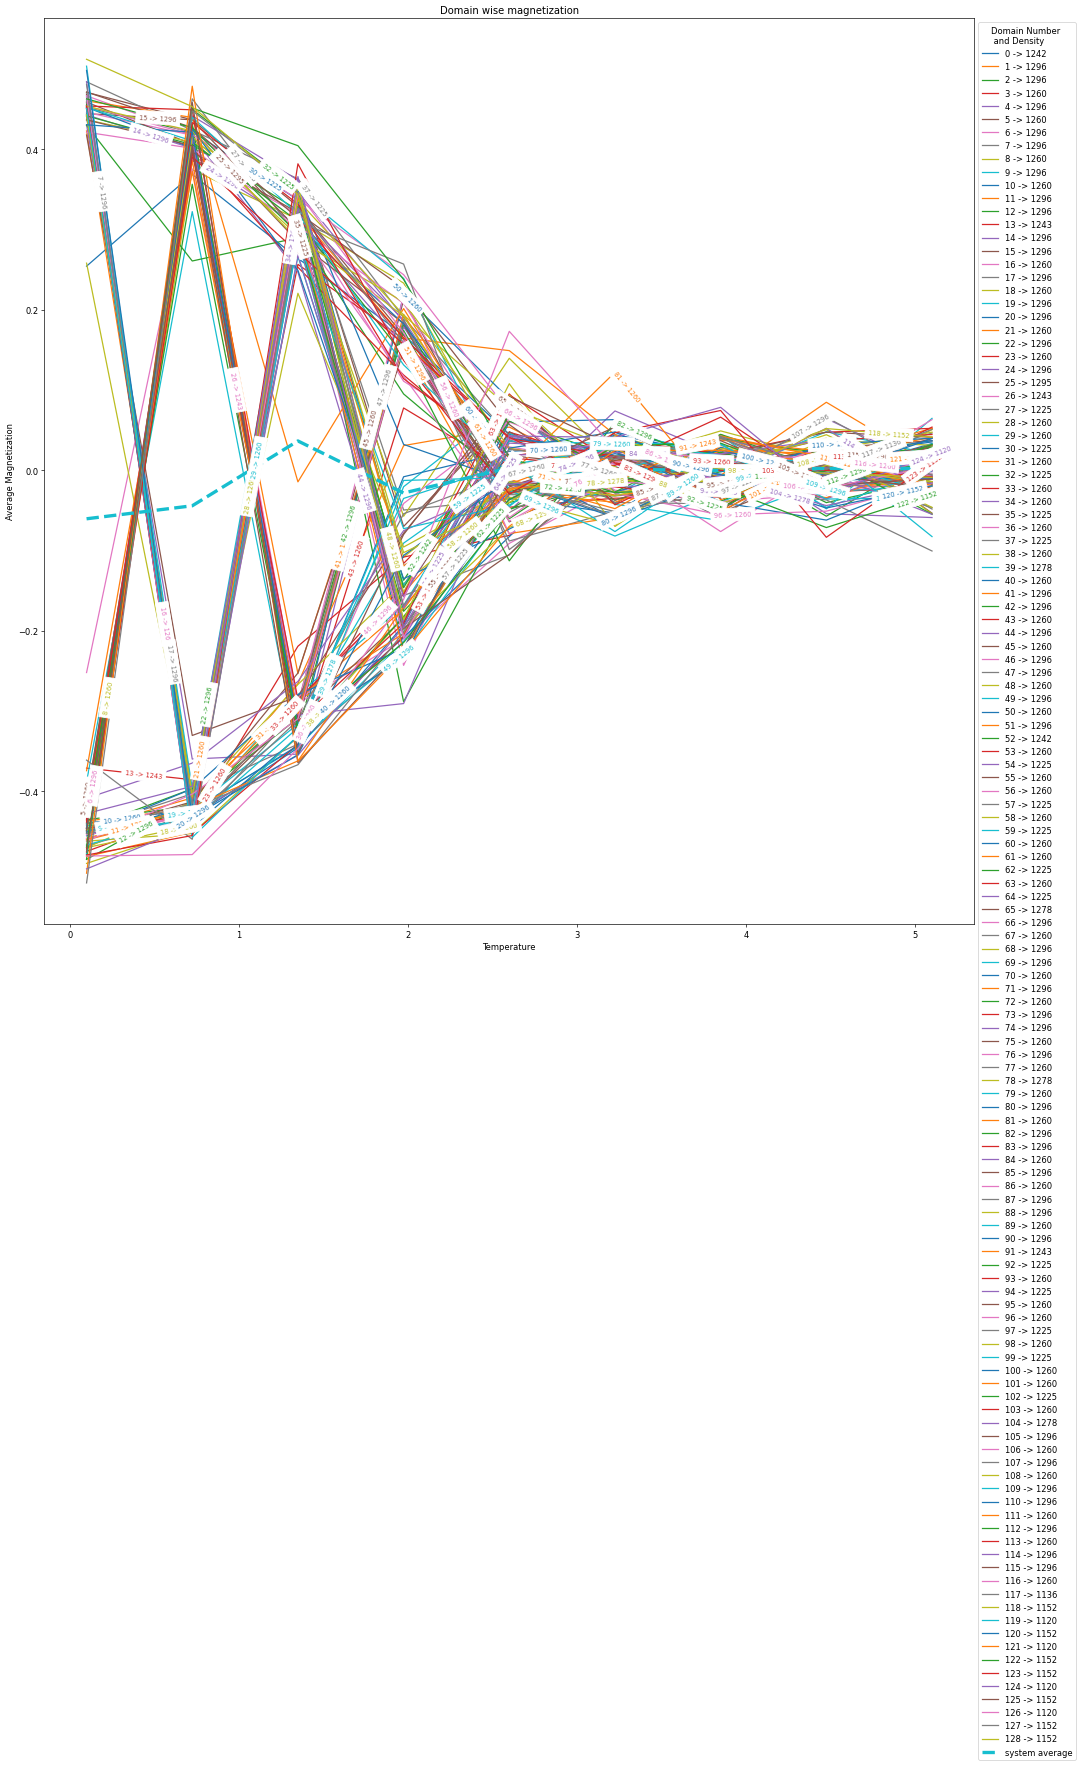

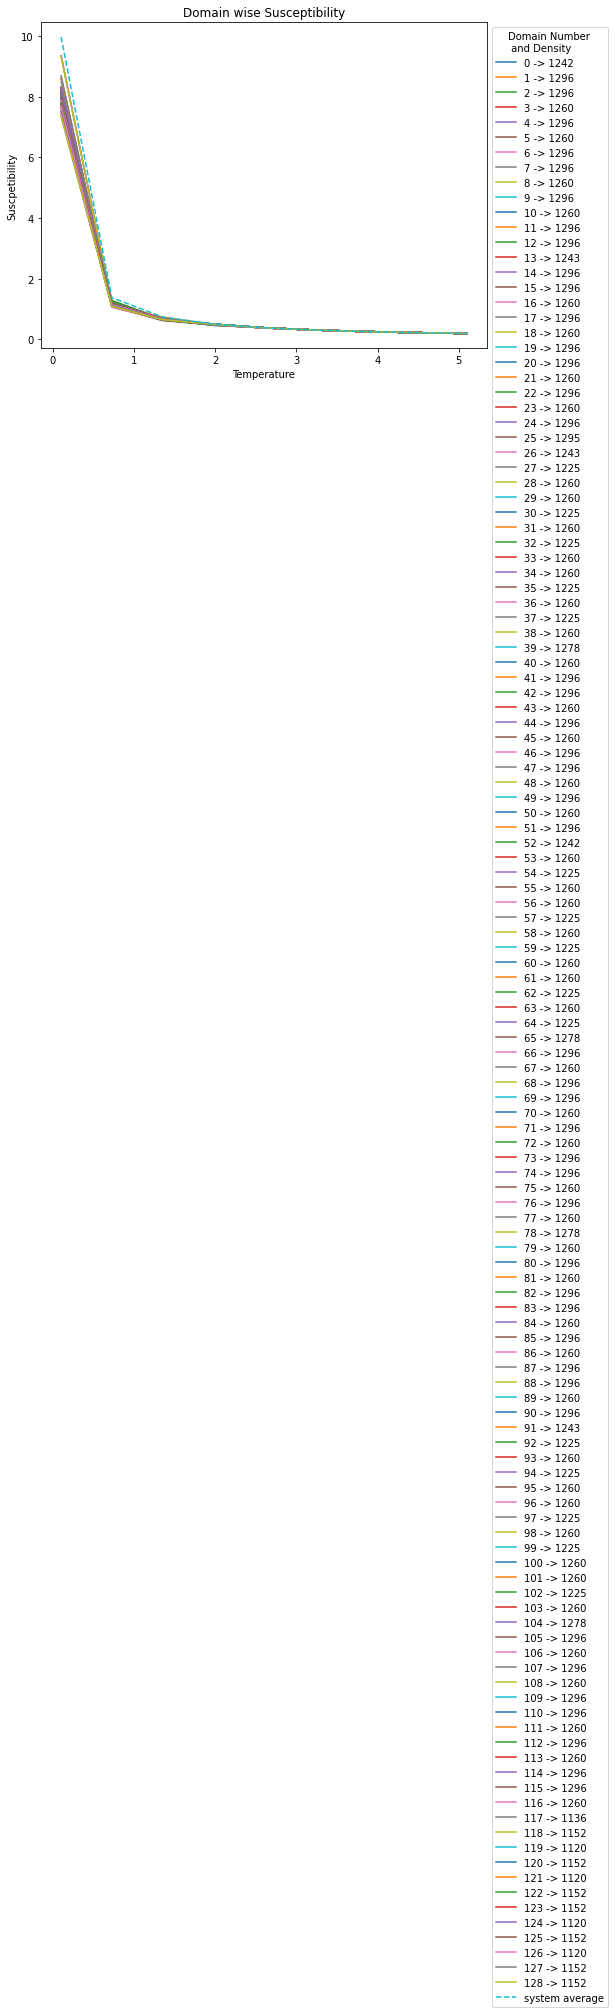

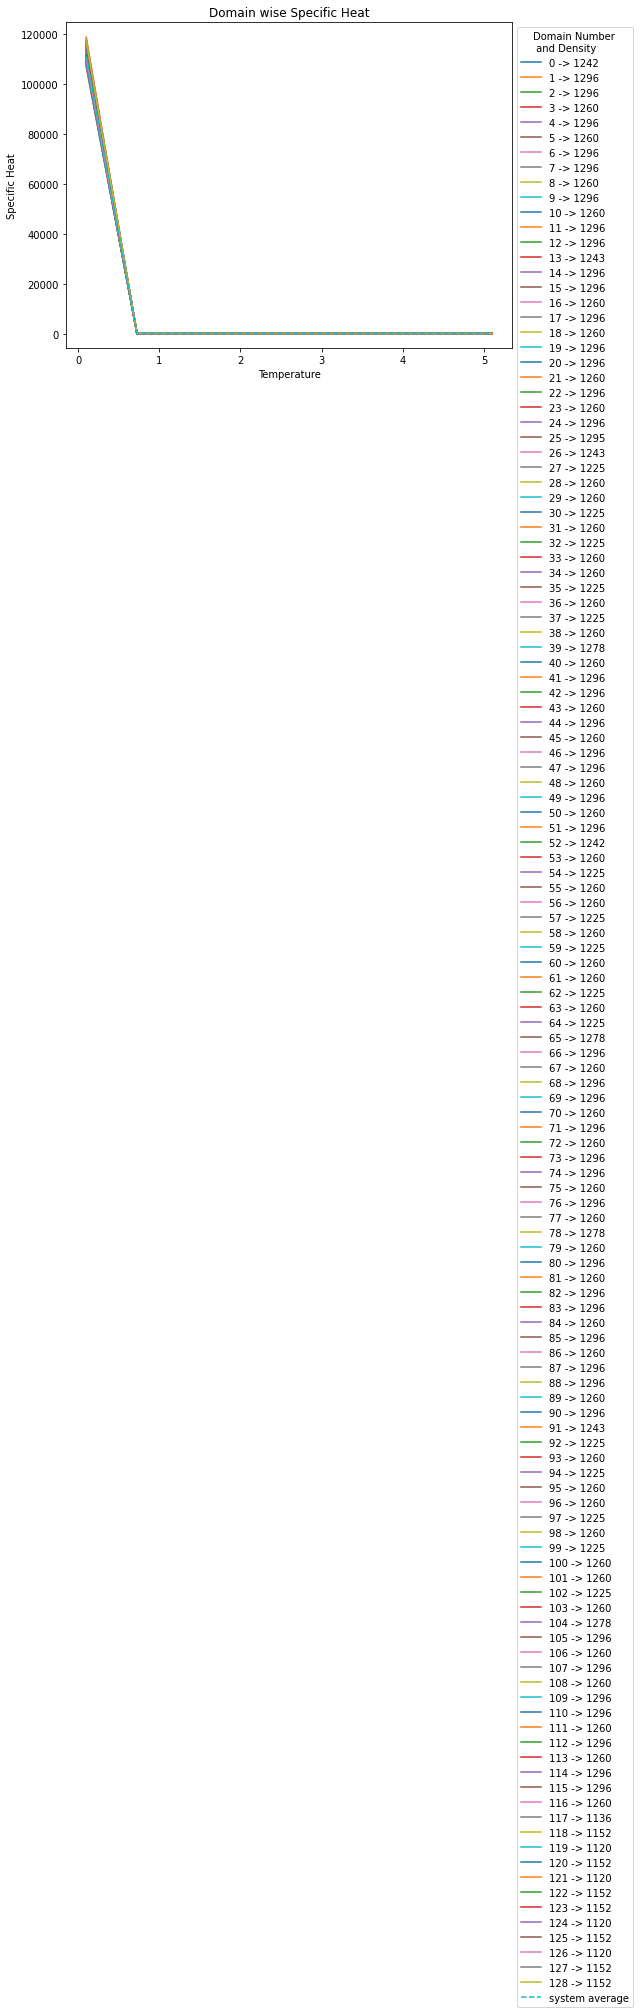

In [22]:
style = dict(size=12, color='black')
figure(num=None, figsize=(20,20), dpi=60, facecolor='w', edgecolor='k')
for i in range(len(unique)-2):
  if (frequencies[i][1] < 1000):
    continue
  else:
    plt.plot(myTval, bank_dom_mag[:,i],label='%d -> %d' %(i,frequencies[i][1]))
plt.plot (myTval,bank_mag[:,-1],'--',label='system average',linewidth = 4) 
labelLines(plt.gca().get_lines(),zorder=2.5, fontsize = 8)
plt.xlabel('Temperature')
plt.ylabel('Average Magnetization')
plt.title('Domain wise magnetization')
plt.legend(title='Domain Number \n and Density',bbox_to_anchor=(1, 1),fancybox='True')
plt.show()

for i in range(len(unique)-2):
  if (frequencies[i][1] < 1000):
    continue
  else:
    plt.plot(myTval, bank_dom_susc[:,i],label='%d -> %d' %(i,frequencies[i][1]))
plt.plot (myTval,bank_avg_susc,'--',label='system average') 
plt.title('Domain wise Susceptibility')
plt.xlabel('Temperature')
plt.ylabel('Suscpetibility')
plt.legend(title='Domain Number \n and Density',bbox_to_anchor=(1, 1),fancybox='True')
plt.show()

for i in range(len(unique)-2):
  if (frequencies[i][1] < 1000):
    continue
  else:
    plt.plot(myTval, bank_dom_Cv[:,i],label='%d -> %d' %(i,frequencies[i][1]))
plt.plot (myTval,bank_avg_Cv,'--',label='system average') 
plt.xlabel('Temperature')
plt.ylabel('Specific Heat')
plt.title('Domain wise Specific Heat')
plt.legend(title='Domain Number \n and Density',bbox_to_anchor=(1, 1),fancybox='True')
plt.show()


In [25]:
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('Copy of Copy of Untitled4.ipynb')

File ‘colab_pdf.py’ already there; not retrieving.





[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Copy of Copy of Untitled4.ipynb to pdf
[NbConvertApp] Support files will be in Copy of Copy of Untitled4_files/
[NbConvertApp] Making directory ./Copy of Copy of Untitled4_files
[NbConvertApp] Making directory ./Copy of Copy of Untitled4_files
[NbConvertApp] Making directory ./Copy of Copy of Untitled4_files
[NbConvertApp] Making directory ./Copy of Copy of Untitled4_files
[NbConvertApp] Making directory ./Copy of Copy of Untitled4_files
[NbConvertApp] Making directory ./Copy of Copy of Untitled4_files
[NbConvertApp] Making directory ./Copy of Copy of Untitled4_files
[NbConvertApp] Making directory ./Copy of Copy of Untitled4_files
[NbConvertApp] Making directory ./Copy of Copy of Untitled4_files
[NbConvertApp] Making directory ./Copy of Copy of Untitled4_files
[NbConvertApp] Making directory ./Copy of Copy of Untitled4_files
[NbConvertApp] Making directory 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'File ready to be Downloaded and Saved to Drive'